In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

import cmocean
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

    
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
zc=np.array([-481.68085,-446.76865,-414.0377,-383.35178,-354.58304,-327.6118,-302.32565,-278.61935,
                           -256.39423,-235.5577,-216.02301,-197.70883,-180.5389,-164.44174,-149.3503,-135.20177,
                           -121.937225,-109.50143,-97.84261,-86.91223,-76.664764,-67.05755,-58.050587,-49.60637,
                           -41.689735,-34.267727,-27.309437,-20.785896,-14.669938,-8.9361,-3.5605056,-0.5])

## train one RF for each depth

In [3]:
def train_rf_mlr(x_train,y_train,random_state=0):
    """
    x_train (arr): input, size (n_samples, n_features)
    y_train (arr): output, size (n_samples, 2). 1st column is true output, other columns are baseline
    """
    RandomForestRegModel = RandomForestRegressor(random_state=random_state)
    RandomForestRegModel.fit(x_train,y_train[:,0])
    
    mlr_model = linear_model.LinearRegression()
    mlr_model.fit(x_train, y_train[:,0])

    return RandomForestRegModel, mlr_model

In [4]:
def test_rf_mlr(x_test, y_test,rf_model, mlr_model):
    """
    x_test (arr): size (n_samples, n_features)
    y_test (arr): size (n_samples, 2) 1st column is true output, other columns are baseline
    """
    # evaluation on test set
    rf_pred = rf_model.predict(x_test)
    rf_test_mse = mean_squared_error(y_test[:,0],rf_pred)
    
    mlr_pred = mlr_model.predict(np.squeeze(x_test))
    mlr_test_mse = mean_squared_error(y_test[:,0],mlr_pred)
    
    w_rms_test=(np.sum(y_test[:,0]**2)/len(rf_pred))**0.5
    
    # divergence baseline: 
    div_test_mse = mean_squared_error(y_test[:,0],y_test[:,1])

    return rf_test_mse, mlr_test_mse, div_test_mse, w_rms_test 

In [7]:
# compile training data
#with open(datadir,'rb') as f:
#    x,y = pickle.load(f)
    
res = 1
datadir1 = 'training_samples_mld_N2_1km/grad_rho_day10.pkl'
#datadir2 = 'training_samples_mld_N2_%ikm/day5.pkl'%res
#datadir3 = 'training_samples_mld_N2_%ikm/day15.pkl'%res

with open(datadir1,'rb') as f:
    x1,y1 = pickle.load(f)
#with open(datadir2,'rb') as f:
#    x2,y2 = pickle.load(f)
#with open(datadir3,'rb') as f:
#    x3,y3 = pickle.load(f)
    
x0 = x1[:,:8]
y0 = y1#np.vstack((y1,y2,y3))

In [8]:
print(x0.shape)

(127395, 8, 1)


In [9]:
feat_importance=[]
coeffs = []
intercepts = []
rf_models=[]
mlr_models=[]

rf_test_mse_depth = []
mlr_test_mse_depth = []
div_test_mse_depth = []
w_rms_test_depth = []
    
# loop over depths (train a separate RF model for each depth)
for i in range(len(zc)):
    print(zc[i])

    # calculate divergence baseline
    depth = -zc[i]
    y_baseline = x0[:,4,:]*depth
    y = np.hstack((y0[:,i,:],y_baseline)) # first column is actual w, second column is baseline
    print(y.shape)
    # train RF & MLR model
    x_train, x_test, y_train, y_test = train_test_split(x0[:,:,0], y, test_size=0.25,random_state=0)
    
    rf_model, mlr_model = train_rf_mlr(x_train,y_train,random_state=0)
    rf_models.append(rf_model)
    mlr_models.append(mlr_model)
    feat_importance.append(rf_model.feature_importances_)
    coeffs.append(mlr_model.coef_)
    intercepts.append(mlr_model.intercept_)
    
    # evaluation on test set
    rf_test_mse, mlr_test_mse, div_test_mse, w_rms_test = test_rf_mlr(x_test, y_test,rf_model, mlr_model)
    rf_test_mse_depth.append(rf_test_mse)
    mlr_test_mse_depth.append(mlr_test_mse)
    div_test_mse_depth.append(div_test_mse)
    w_rms_test_depth.append(w_rms_test)

-481.68085
(127395, 2)
-446.76865
(127395, 2)
-414.0377
(127395, 2)
-383.35178
(127395, 2)
-354.58304
(127395, 2)
-327.6118
(127395, 2)
-302.32565
(127395, 2)
-278.61935
(127395, 2)
-256.39423
(127395, 2)
-235.5577
(127395, 2)
-216.02301
(127395, 2)
-197.70883
(127395, 2)
-180.5389
(127395, 2)
-164.44174
(127395, 2)
-149.3503
(127395, 2)
-135.20177
(127395, 2)
-121.937225
(127395, 2)
-109.50143
(127395, 2)
-97.84261
(127395, 2)
-86.91223
(127395, 2)
-76.664764
(127395, 2)
-67.05755
(127395, 2)
-58.050587
(127395, 2)
-49.60637
(127395, 2)
-41.689735
(127395, 2)
-34.267727
(127395, 2)
-27.309437
(127395, 2)
-20.785896
(127395, 2)
-14.669938
(127395, 2)
-8.9361
(127395, 2)
-3.5605056
(127395, 2)
-0.5
(127395, 2)


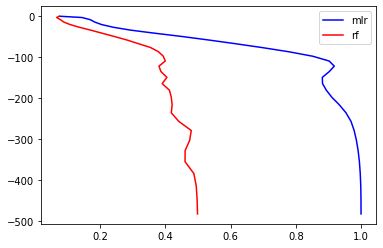

In [10]:
#print(mlr_test_mse_depth[0]**0.5)
#print(rf_test_mse_depth[0]**0.5)
plt.plot(np.array(mlr_test_mse_depth)**0.5/np.array(w_rms_test_depth), zc,'b')
plt.plot(np.array(rf_test_mse_depth)**0.5/np.array(w_rms_test_depth),zc,'r')
plt.legend(['mlr','rf'])

In [11]:
print(np.array(rf_test_mse_depth)**0.5/np.array(w_rms_test_depth))

[0.49830328 0.49700372 0.49443615 0.48704241 0.46001544 0.46027121
 0.47424468 0.47904769 0.44085215 0.41787501 0.42047585 0.41784621
 0.41218879 0.38999993 0.4044438  0.3862181  0.38007482 0.39953417
 0.39339661 0.37849568 0.35432564 0.31638635 0.28083549 0.24229271
 0.20518071 0.17079607 0.13610816 0.10799749 0.08842099 0.07838362
 0.06662876 0.07416125]


## apply to separate day and plot

In [12]:
with open('training_samples_mld_N2_1km/grad_rho_day5.pkl','rb') as f:
    xd5, yd5 = pickle.load(f)

In [13]:
print(len(xd5))
print(xd5[0].shape)

127395
(9, 1)


## loop over all depths

In [ ]:
with open('trained_models/with_mld_n2/rf_model.pkl','rb') as f1:
    model = pickle.load(f1)
    
rf_models = model['rf_models']
mlr_models = model['mlr_models']

In [14]:
day5_pred=[] # reshaped day 5 predictions for plotting
mse_mlr_depth = []
mse_rf_depth = []
w_mse = []
mse_div_depth = []

for i in range(len(zc)):
    X_newday = xd5[:,:8,0]

    depth = -zc[i]
    rf = rf_models[i]
    mlr = mlr_models[i]
    yd5_rf = rf_models[i].predict(X_newday)
    yd5_div = xd5[:,4,:]*depth
    yd5_mlr = mlr.predict(X_newday)

    mse_rf = (mean_squared_error(yd5[:,i,:],yd5_rf))
    mse_div = (mean_squared_error(yd5[:,i,:],yd5_div)) #baseline mse
    mse_mlr = (mean_squared_error(yd5[:,i,:],yd5_mlr))
    
    w_mse.append(mean_squared_error(yd5[:,i,:],yd5[:,i,:]*0))
    mse_rf_depth.append(mse_rf)
    mse_mlr_depth.append(mse_mlr)
    mse_div_depth.append(mse_div)

In [16]:
#np.save('trained_models/with_mld_n2/mse_mlr.npy', np.array(mse_mlr_depth))
#np.save('trained_models/with_mld_n2/mse_div_depth.npy', np.array(mse_div_depth))
#np.save('trained_models/with_mld_n2/mse_rf.npy', np.array(mse_rf_depth))
#np.save('trained_models/with_mld_n2/mse_w.npy', np.array(w_mse))

[0.0006996646778518234, 0.004262833568463352, 0.005822742288530177, 0.005127791430928081, 0.004481208201091089, 0.004196745892908543, 0.004013666202227949, 0.003991092395536126, 0.004275215709396037, 0.005028170468865819, 0.006056280128160634, 0.006918602350943689, 0.007873347253171388, 0.009798968863307746, 0.013969602221650671, 0.021545170818696304, 0.03301253634188902, 0.045661007636549886, 0.055230145245870776, 0.05955306994771231, 0.05792882661944347, 0.051163618933760896, 0.04108073105732096, 0.02946271296665989, 0.018157331568058696, 0.00976476906075763, 0.004815625960167194, 0.0021878520536855223, 0.0009114680022474311, 0.00029777165231032127, 3.211875977503845e-05, 1.4365641740712904e-07]


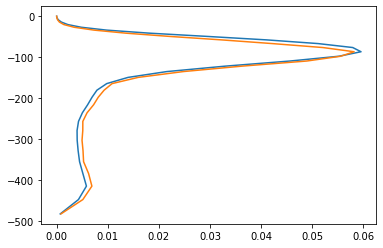

In [15]:
print(mse_mlr_depth)
plt.plot(mse_mlr_depth,zc)
plt.plot(mse_rf_depth,zc)

## feature importance

In [20]:
# plot feature importance
category_names = ['u', 'v',r'$\zeta$', r'$\Delta\rho$', r'$\nabla\cdot\vec{u}$',
                  'MLD', '$N^2$',
r'$\frac{\partial \rho}{\partial y}$']

u_imp=[]
v_imp=[]
vor_imp=[]
rho_imp=[]
div_imp=[]
mld_imp=[]
n2_imp=[]
drdy_imp=[]

for f in feat_importance:
    u_imp.append(f[0])
    v_imp.append(f[1])
    vor_imp.append(f[2])
    rho_imp.append(f[3])
    div_imp.append(f[4])
    mld_imp.append(f[5])
    n2_imp.append(f[6])
    drdy_imp.append(f[7])
    #drdx_imp.append(f[8])
    
var_importance = [u_imp, v_imp, vor_imp, rho_imp, div_imp, mld_imp,n2_imp,drdy_imp]

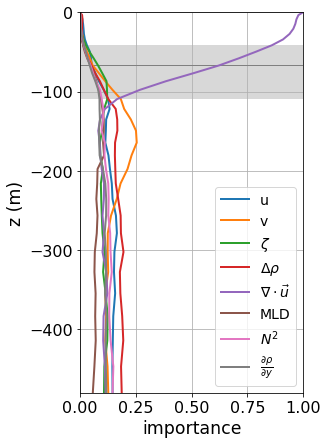

In [22]:
savefigdir='/Users/jing/Desktop/'
mld = x_train[:,5]
x = np.arange(-1,2,0.1)
x1 = np.ones(x.shape)
upper_bound = np.percentile(mld,75,axis=0)*x1
lower_bound = np.percentile(mld,25,axis=0)*x1

#plt.plot(test_set_w_magnitude,depths,'-o')
plt.figure(figsize=(4,7))
for var in var_importance:
    plt.plot(var,zc,linewidth=2)
plt.hlines(np.median(mld),0,1,'gray',linewidth=1,linestyle='-')
plt.fill_between(x, lower_bound, upper_bound, facecolor='gray', alpha=0.3,
                label='1 sigma range')

plt.legend(category_names,fontsize=14)
#plt.legend(['u','v',r'$\zeta$',r'$\Delta\rho$',r'$\nabla_H\cdot\vec{u}$','MLD',r'$N^2_{peak}$'],fontsize=14)

plt.xlim([0,1])
plt.ylim([-480,0])
plt.grid(True)
#plt.legend(['with MLD and N2','without MLD or N2'])
plt.ylabel('z (m)',fontsize='xx-large')
plt.xlabel(r'importance',fontsize='xx-large')
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(savefigdir+'feat_importance_withmld.pdf',bbox_inches='tight')


## MLR coefficients

In [19]:
print(x_train.shape)

(95546, 8)


In [23]:
u_coef=[]
v_coef=[]
vor_coef=[]
rho_coef=[]
div_coef=[]
mld_coef=[]
N2_coef=[]
drho_coef = []

for f in coeffs:
    u_coef.append(f[0]*(np.sum(x_train[:,0]**2)/len(x_train[:,0]))**0.5)
    v_coef.append(f[1]*(np.sum(x_train[:,1]**2)/len(x_train[:,0]))**0.5)
    vor_coef.append(f[2]*(np.sum(x_train[:,2]**2)/len(x_train[:,0]))**0.5)
    rho_coef.append(f[3]*(np.sum(x_train[:,3]**2)/len(x_train[:,0]))**0.5)
    div_coef.append(f[4]*(np.sum(x_train[:,4]**2)/len(x_train[:,0]))**0.5)
    mld_coef.append(f[5]*(np.sum(x_train[:,5]**2)/len(x_train[:,0]))**0.5)
    N2_coef.append(f[6]*(np.sum(x_train[:,6]**2)/len(x_train[:,0]))**0.5)
    drho_coef.append(f[7]*(np.sum(x_train[:,7]**2)/len(x_train[:,0]))**0.5)

    #n2_coef.append(f[6]*(np.sum(x_train[:,6]**2)/len(x_train[:,0]))**0.5)
    

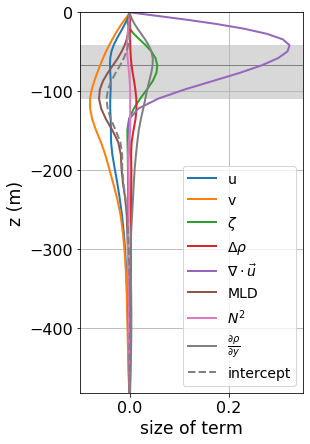

In [25]:
savefigdir='/Users/jing/Desktop/'

plt.figure(figsize=(4,7))
plt.plot(u_coef,zc,v_coef,zc,vor_coef,zc,rho_coef,zc,div_coef,zc,mld_coef,zc,N2_coef,zc,drho_coef,zc,linewidth=2)
plt.plot(intercepts,zc,'--',linewidth=2,color='gray')
plt.hlines(np.median(mld),-0.1,1.5,'gray',linewidth=1,linestyle='-')
plt.fill_between(x, lower_bound, upper_bound, facecolor='gray', alpha=0.3,
                label='1 sigma range')

plt.legend(category_names+['intercept'],fontsize=14)

plt.xlim([-0.1,0.35])
plt.ylim([-482,0])
plt.grid(True)
#plt.legend(['with MLD and N2','without MLD or N2'])
plt.ylabel('z (m)',fontsize='xx-large')
plt.xlabel(r'size of term',fontsize='xx-large')
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(savefigdir+'coefficient_withmld.pdf',bbox_inches='tight')


In [ ]:
## normalize by wrms at each depth
plt.figure(figsize=(4,7))
plt.plot(np.array(u_coef)/w_rms_test_depth,zc,np.array(v_coef)/w_rms_test_depth,zc,
         np.array(vor_coef)/w_rms_test_depth,zc,np.array(rho_coef)/w_rms_test_depth,zc,
         np.array(div_coef)/w_rms_test_depth,zc,np.array(drho_coef)/w_rms_test_depth,zc,
         linewidth=2)

plt.plot(np.array(intercepts)/w_rms_test_depth,zc,'--',linewidth=2,color='gray')
plt.hlines(np.median(mld),-1,1.5,'gray',linewidth=1,linestyle='-')
plt.fill_between(x, lower_bound, upper_bound, facecolor='gray', alpha=0.3,
                label='1 sigma range')

plt.legend(category_names+['intercept'],fontsize=14)

plt.xlim([-1,1.5])
plt.ylim([-482,0])
plt.grid(True)
#plt.legend(['with MLD and N2','without MLD or N2'])
plt.ylabel('z (m)',fontsize='xx-large')
plt.xlabel(r'size of term',fontsize='xx-large')
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(savefigdir+'coefficient_normalized.pdf',bbox_inches='tight')

In [ ]:
## normalize by wrms at each depth
plt.figure(figsize=(4,7))
plt.plot(np.abs(np.array(u_coef)/w_rms_test_depth),zc,np.abs(np.array(v_coef)/w_rms_test_depth),zc,
         np.abs(np.array(vor_coef)/w_rms_test_depth),zc,np.abs(np.array(rho_coef)/w_rms_test_depth),zc,
         np.abs(np.array(div_coef)/w_rms_test_depth),zc,
         np.abs(np.array(drho_coef)/w_rms_test_depth),zc,linewidth=2)

plt.plot(np.abs(np.array(intercepts)/w_rms_test_depth),zc,'--',linewidth=2,color='gray')
plt.hlines(np.median(mld),-1,1.5,'gray',linewidth=1,linestyle='-')
plt.fill_between(x, lower_bound, upper_bound, facecolor='gray', alpha=0.3,
                label='1 sigma range')

plt.legend(['u','v',r'$\zeta$',r'$\Delta\rho$',r'$\nabla_H\cdot\vec{u}$','drho_dy','intercept'],fontsize=14)

plt.xlim([0,1])
plt.ylim([-482,0])
plt.grid(True)
#plt.legend(['with MLD and N2','without MLD or N2'])
plt.ylabel('z (m)',fontsize='xx-large')
plt.xlabel(r'size of term',fontsize='xx-large')
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(savefigdir+'coefficient_normalized_absolute_value.pdf',bbox_inches='tight')

### misc

In [26]:
mld = xd5[:,5]
print(np.mean(mld))
print(np.median(mld))
print(np.min(mld))
print(np.max(mld))
print(np.std(mld))
print(np.percentile(mld, 25, axis=0))
print(np.percentile(mld, 75, axis=0))

-74.50927484271003
-67.06476400000055
-197.72301000000104
-8.96993800000002
37.95170383063892
[-109.537225]
[-41.70637]


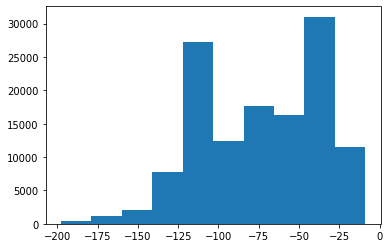

In [27]:
plt.hist(mld);

# Save model

In [28]:
## Save model
model_save = {'inputs_label':category_names,
              'rf_models':rf_models,
              'mlr_models': mlr_models,
              'feat_importance': var_importance,
              'rf_test_mse': rf_test_mse_depth,
              'mlr_test_mse': mlr_test_mse_depth,
              'div_test_mse': div_test_mse_depth,
              'w_rms_test': w_rms_test_depth,
              'coeffs': coeffs,
              'intercepts': intercepts,
              'zc': zc,
              'mld':mld}

with open('trained_models/with_mld_n2/rf_model.pkl','wb') as f:
    pickle.dump(model_save,f)